# Overview
- 全てのaudiofileのスペクトログラムを画像として保存する。

# Const

In [11]:
NB = '005'
DIR_AUDIO = './../data_ignore/official/train_audio'
DIR_SPECTROGRAM_IMAGES = './../data/info/images/train_spectrogram/'
PATH_TRAIN_CSV = './../data_ignore/official/train.csv'

# Import everything I need :)

In [2]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import librosa
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import seaborn as sns

# My function

In [20]:
def extract_mfccs(x, sr, n_fft, hop_length, n_mels):
    mfccs = librosa.feature.mfcc(y=x,
                                 sr=sr,
                                 n_fft=n_fft,
                                 hop_length=hop_length,
                                 center=False,
                                 n_mels=n_mels)
    feat_name = [f'librosa_mfcc_{i+1}' for i in range(n_mels)]
    return mfccs.T, feat_name

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in progress_bar(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def plot_signal2spec(data, title=None, n_fft=22050, hop_length=11025, sr=44100, min_hz=0, max_hz=22050, cool_ticks=False):
    '''plot a spectrogram of signal data
    Args:
        data (numpy.ndarray): 信号データ(音データ等)
        title (str): タイトル
        n_fft (int): specを作るときの窓幅
        hop_length (int): specを作るときの窓を動かす幅
        sr (int): specの元データのサンプリングレート
        min_hz (int): 描画する最小の周波数
        max_hz (int): 描画する最大の周波数
    '''
    spec = np.abs(librosa.stft(data, n_fft=n_fft, hop_length=hop_length))
    spec = librosa.amplitude_to_db(spec)
    secs = len(data) / sr
    plt.figure(figsize=(10, 5))
    plt.imshow(spec,
               aspect='auto',
               origin='lower',
               cmap=None,
               extent=(0, secs, 0, int(sr/2)))
    plt.xlabel('time(sec)')
    plt.ylabel('Hz')
    plt.ylim(min_hz, max_hz)
#     plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    if cool_ticks:
        sec_list = np.arange(len(data))/sr
        n = 5
        interval = len(sec_list)//n
        label_index = sec_list[::interval]
        label = [sec2time(sec) for sec in label_index]
        plt.xticks(label_index, label)
    plt.show()

# Preparation

settings

In [4]:
pd.set_option('display.max_columns', 100)

<br>
load train.csv

In [5]:
df_train = pd.read_csv(PATH_TRAIN_CSV)
df_train.head(2)

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,number_of_notes,title,secondary_labels,bird_seen,sci_name,location,latitude,sampling_rate,type,elevation,description,bitrate_of_mp3,file_type,volume,background,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,Not specified,XC134874 Alder Flycatcher (Empidonax alnorum),"['Empidonax minimus_Least Flycatcher', 'Leioth...",yes,Empidonax alnorum,"Grey Cloud Dunes SNA, Washington, Minnesota",44.793,48000 (Hz),call,220 m,Two short segments of fairly quiet *pip* calls...,192000 (bps),mp3,Not specified,American Yellow Warbler (Setophaga aestiva); L...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,1-3,XC135454 Alder Flycatcher (Empidonax alnorum),[],yes,Empidonax alnorum,"Carver's Gap Parking area, Roan Mountain Stat...",36.1065,44100 (Hz),"call, song",1700 m,At least three birds seen here moving around s...,128000 (bps),mp3,level,NaN,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


# Execution

In [6]:
dir_birds = glob.glob(f'{DIR_AUDIO}/*')
dir_birds = sorted(dir_birds)
dir_birds[:3]

['./../data_ignore/official/train_audio/aldfly',
 './../data_ignore/official/train_audio/ameavo',
 './../data_ignore/official/train_audio/amebit']

In [52]:
df_list = []
for dir_bird in progress_bar(dir_birds):
    audio_files = glob.glob(f'{dir_bird}/*')
    audio_files = sorted(audio_files)
    for audio_file in audio_files[:1]:
#     for audio_file in audio_files:
        window_size = 0.5  # sec
        signal, sr = librosa.load(audio_file, sr=None)
        
        n_fft = int(sr * window_size)
        hop_length = int(n_fft/2)
        feat_val, feat_name = extract_mfccs(signal,
                                            sr=sr,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            n_mels=12,
                                           )
        feat_val = feat_val.mean(axis=0)
        df_feat = pd.DataFrame([feat_val], columns=feat_name)
        df_feat = df_feat.drop(['librosa_mfcc_1'], axis=1)
        df_feat['birds'] = dir_bird.split('/')[-1]
        df_list.append(df_feat)
        
df_merge01 = pd.concat(df_list)
df_merge01 = df.reset_index(drop=True)

In [8]:
dir_bird = dir_birds[0]
dir_bird

'./../data_ignore/official/train_audio/aldfly'

In [10]:
audio_files = glob.glob(f'{dir_bird}/*')
audio_files = sorted(audio_files)
path = audio_files[0]

In [15]:
signal, sr = librosa.load(path, sr=None)

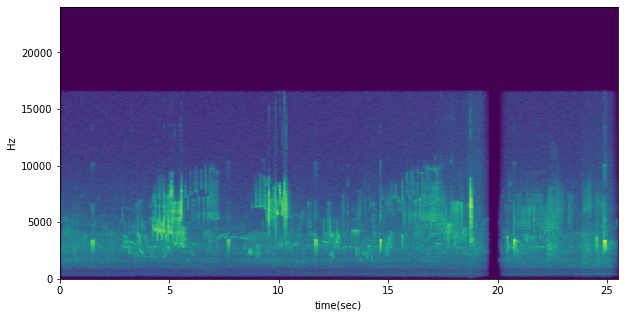

In [30]:
n_fft = int(sr * 0.2)
hop_length = int(n_fft/2)
plot_signal2spec(signal, sr=sr, n_fft=n_fft, hop_length=hop_length, max_hz=int(sr/2), )